# Normalizing flows
Deconvolving 3 Perpendicular Gaussians with MAFs

In [1]:
from deconvolution.trainer.trainer import Trainer
from deconvolution.configs.toys_configs import Deconvolve_Toys_Couplings_RQS_NormFlow as Configs

configs = Configs(DATA = 'smeared_gaussians',
                  NUM_POINTS = 100000,
                  DATA_SPLIT_FRACS = [0.5, 0.5, 0.0],
                  DATA_LOC = 0,
                  DATA_SCALE = 1,
                  PREPROCESS = None, 
                  NOISE_COV = [[0.1, 0],[0, 1]],
                  BATCH_SIZE = 512,
                  EPOCHS = 20,
                  EARLY_STOPPING = 20,
                  MIN_EPOCHS = 50,
                  NUM_GEN_SAMPLES = 12000,
                  NUM_TRANSFORMS = 5,
                  DIM_HIDDEN = 32, 
                  NUM_NOISE_DRAWS = 50,
                  COUPLING_MASK = 'mid-split',
                  NUM_BLOCKS = 2,
                  USE_RESIDUAL_BLOCKS = True,
                  USE_BATCH_NORM = True,               
                  NUM_RQS_BINS = 20,
                  TAIL_BOUND = 10,
                  PRINT_EPOCHS = 5,
                  LR = 1e-4,
                  DROPOUT = 0.2,
                  NUM_WORKERS = 8,
                  PIN_MEMORY = True,
                  DEVICE = 'cpu')
 
#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

Preparing experiment: deconvolution for smeared Gaussian mixture data at workdir:
#=========================================================================================================
INFO: created directory: ../../results/smeared_gaussians.DeconvolutionFlow.Couplings_RQS.2024.02.01_21h08
#=========================================================================================================
+---------------------+--------------------+
| Parameters          | Values             |
+---------------------+--------------------+
| DATA                | smeared_gaussians  |
| FEATURES            | ['x', 'y']         |
| NUM_POINTS          | 100000             |
| DIM_INPUT           | 2                  |
| DATA_LOC            | 0                  |
| DATA_SCALE          | 1                  |
| NOISE_COV           | [[0.1, 0], [0, 1]] |
| PREPROCESS          |                    |
| CUTS                | x: [-inf, inf]     |
|                     | y: [-inf, inf]     |
| DEVICE     

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.5/0.5/0.0
INFO: train size: 50000, validation size: 50000, testing sizes: 0


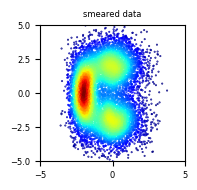

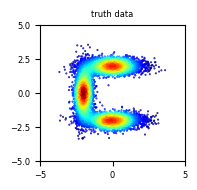

In [2]:
from utils import plot_gaussians
from deconvolution.datamodules.toys.datasets import SmearedGaussDataset
from deconvolution.datamodules.toys.dataloader import ToysDataLoader 

gaussians = SmearedGaussDataset(configs)
dataloader = ToysDataLoader(gaussians, configs)

plot_gaussians(gaussians.target, title='smeared data', num_points=10000, xlim=(-5,5), ylim=(-5,5))
if configs.PREPROCESS is not None:
    plot_gaussians(gaussians.target_preprocess, title='smeared preprocess data', num_points=10000, xlim=(-3, 3), ylim=(-3,3))
plot_gaussians(gaussians.truth, title='truth data', num_points=10000, xlim=(-5,5), ylim=(-5,5))


In [3]:
from deconvolution.models.nflow_nets import CouplingsPiecewiseRQS
from deconvolution.dynamics.nf.normflows import DeconvolutionFlow

flow = Trainer(dynamics = DeconvolutionFlow(configs), 
               model = CouplingsPiecewiseRQS(configs), 
               dataloader = dataloader, 
               configs = configs)

flow.train()

number of training parameters: 38946
start training...


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

	Epoch: 1, train loss: 3.6909573589052487, valid loss: 3.653535487700483  (min valid loss: 3.653535487700483)
	Epoch: 6, train loss: 3.6194318362644733, valid loss: 3.6246007486265523  (min valid loss: 3.624355780835055)


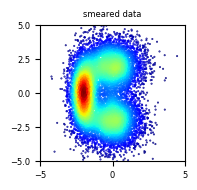

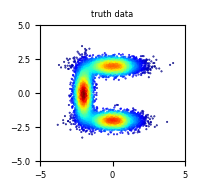

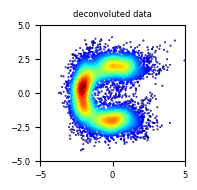

In [11]:
from deconvolution.pipelines.SamplingPipeline import NormFlowPipeline 
from deconvolution.datamodules.toys.dataprocess import PostProcessGaussData

pipeline = NormFlowPipeline(trained_model=flow,
                            best_epoch_model=True)


pipeline.generate_samples(num=12000)

plot_gaussians(gaussians.target, title='smeared data', num_points=12000, xlim=(-5,5), ylim=(-5,5))
plot_gaussians(gaussians.truth, title='truth data', num_points=12000, xlim=(-5,5), ylim=(-5,5))
plot_gaussians(pipeline.target, title='deconvoluted data', num_points=12000, xlim=(-5,5), ylim=(-5,5))

In [6]:
gaussians.covs

tensor([[[ 1.6000,  0.0000],
         [ 0.0000, 16.0000]],

        [[ 1.6000,  0.0000],
         [ 0.0000, 16.0000]],

        [[ 1.6000,  0.0000],
         [ 0.0000, 16.0000]],

        ...,

        [[ 1.6000,  0.0000],
         [ 0.0000, 16.0000]],

        [[ 1.6000,  0.0000],
         [ 0.0000, 16.0000]],

        [[ 1.6000,  0.0000],
         [ 0.0000, 16.0000]]])

In [7]:
gaussians.summary_stats['std']

tensor([5.1953, 8.0089])

In [10]:
gaussians.noise_cov / gaussians.summary_stats['std']

tensor([[0.3080, 0.0000],
        [0.0000, 1.9978]])